In [ ]:
# !pip install imblearn

In [ ]:
!pip install sklearn

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# Carica il dataset
df = pd.read_csv('only_one_language_country.csv')

In [ ]:
bins = [0, 50000000, 500000000, np.inf]  # Specifica i tuoi bin qui
labels = ['0-50,000,000','50,000,000-500,000,000', '500,000,000+']  # Etichette per i bin
df['revenue_cluster'] = pd.cut(df['revenue_with_CPI'], bins=bins, labels=labels, right=False)

# Seleziona le colonne rilevanti
columns_to_keep = [
    'genre', 'duration_df1','date_published', 'language', 'country', 'converted_budget',
    'dir_oscar_nomination', 'dir_oscar_won', 'writer_oscar_nomination',
    'BAFTA_nominees','BAFTA_awards',
    'writer_oscar_won', 'cast_oscar_nomination', 'cast_oscar_won',
    'dir_globe_nomination', 'dir_globe_won', 'production_company_df1',
    'cast_globe_nomination', 'cast_globe_won','actors_films_before','director_films_before', 'writers_films_before','revenue_cluster'
]

df_selected = df[columns_to_keep].dropna()
# Visualizza le prime righe del dataset selezionato
print(df_selected.head())

# Funzione per one-hot encoding su colonne con valori multipli separati da virgole
def multi_value_one_hot(df, column):
    s = df[column].str.get_dummies(sep=', ')
    return df.join(s.add_prefix(column + '_'))

# Converti 'date_published' in formato datetime
df_selected['date_published'] = pd.to_datetime(df_selected['date_published'], errors='coerce')

# Estrai il mese dalla colonna 'date_published'
df_selected['month_published'] = df_selected['date_published'].dt.month

# Rimuovi la colonna 'date_published'
df_selected.drop(columns=['date_published'], inplace=True)

# Applica one-hot encoding alle colonne 'genre'
df_selected = multi_value_one_hot(df_selected, 'genre')

# Rimuovi le colonne originali 'genre'
df_selected.drop(columns=['genre'], inplace=True)

X = df_selected.drop('revenue_cluster', axis=1)
y = df_selected['revenue_cluster']
print(X.head())




In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definisci le colonne categoriche
# needed for SMOTENC algorithm
categorical_features = ['language', 'country', 'production_company_df1', 'month_published']
categorical_features += [col for col in X.columns if col.startswith('genre_')]

# Trova il numero di campioni della seconda classe più numerosa
class_counts = y_train.value_counts()
second_most_common_count = class_counts.nlargest(2).iloc[-1]

# Applica l'undersampling sulla classe maggioritaria riducendo al numero della seconda classe più numerosa
rus = RandomUnderSampler(sampling_strategy={class_counts.idxmax(): second_most_common_count}, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Applica SMOTENC solo sui dati di training dopo l'undersampling
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train_resampled, y_train_resampled)

print(X_train_resampled.head())

In [158]:
# Applica one-hot encoding alla colonna 'month_published'
X_train_resampled = pd.get_dummies(X_train_resampled, columns=['month_published'], prefix='month')
X_test = pd.get_dummies(X_test, columns=['month_published'], prefix='month')

# Mantieni solo le colonne dei mesi
month_columns = [col for col in X_train_resampled.columns if col.startswith('month_')]
X_train_resampled = X_train_resampled[month_columns + [col for col in X_train_resampled.columns if not col.startswith('month_')]]

month_columns = [col for col in X_test.columns if col.startswith('month_')]
X_test = X_test[month_columns + [col for col in X_test.columns if not col.startswith('month_')]]


# Applica one-hot encoding alle colonne 'genre', 'language', 'country' e 'production_company_df1'
X_train_resampled = multi_value_one_hot(X_train_resampled, 'language')
X_train_resampled = multi_value_one_hot(X_train_resampled, 'country')
X_train_resampled = multi_value_one_hot(X_train_resampled, 'production_company_df1')


X_test = multi_value_one_hot(X_test, 'language')
X_test = multi_value_one_hot(X_test, 'country')
X_test = multi_value_one_hot(X_test, 'production_company_df1')

# Rimuovi le colonne originali 'genre', 'language', 'country' e 'production_company_df1'
X_train_resampled.drop(columns=['language', 'country', 'production_company_df1'], inplace=True)
X_test.drop(columns=['language', 'country', 'production_company_df1'], inplace=True)

# Rimuovi righe con NaN nella colonna 'converted_budget'
#df_selected = df_selected.dropna(subset=['converted_budget'])

# Normalizzazione delle variabili numeriche

scaler = StandardScaler()
numerical_columns = ['duration_df1', 'converted_budget', 
                     'dir_oscar_nomination', 'dir_oscar_won', 
                     'writer_oscar_nomination', 'writer_oscar_won', 
                     'cast_oscar_nomination', 'cast_oscar_won', 
                     'dir_globe_nomination', 'dir_globe_won', 
                     'cast_globe_nomination', 'cast_globe_won',
                     'BAFTA_nominees','BAFTA_awards',
                     'actors_films_before', 'director_films_before', 'writers_films_before']
X_train_resampled[numerical_columns] = scaler.fit_transform(X_train_resampled[numerical_columns])
X_test[numerical_columns] = scaler.fit_transform(X_test[numerical_columns])

# Check: train e test devono avere stesse colonne 
X_train_resampled, X_test = X_train_resampled.align(X_test, join='outer', axis=1, fill_value=0)

#X_train_resampled = X_train_resampled[selected_features_mi.to_list()]
#X_test = X_test[selected_features_mi.to_list()]

# Verifichiamo il risultato
print(X_train_resampled.head())

   BAFTA_awards  BAFTA_nominees  actors_films_before  cast_globe_nomination  \
0     -0.068688        -0.19533            -0.533442              -0.541485   
1     -0.068688        -0.19533            -0.649320              -0.541485   
2     -0.068688        -0.19533            -0.533442              -0.541485   
3     -0.068688        -0.19533             1.030915               0.881009   
4     -0.068688        -0.19533            -0.649320              -0.541485   

   cast_globe_won  cast_oscar_nomination  cast_oscar_won  converted_budget  \
0       -0.440611              -0.493351       -0.369644          0.095226   
1       -0.440611              -0.493351       -0.369644         -0.616884   
2       -0.440611              -0.493351       -0.369644         -0.515031   
3        2.639880               0.648468        1.139367         -0.366742   
4       -0.440611              -0.493351       -0.369644         -0.326761   

   country_Canada  country_France  ...  production_compa

One hot encoding sul train set prima di applicare oversampling

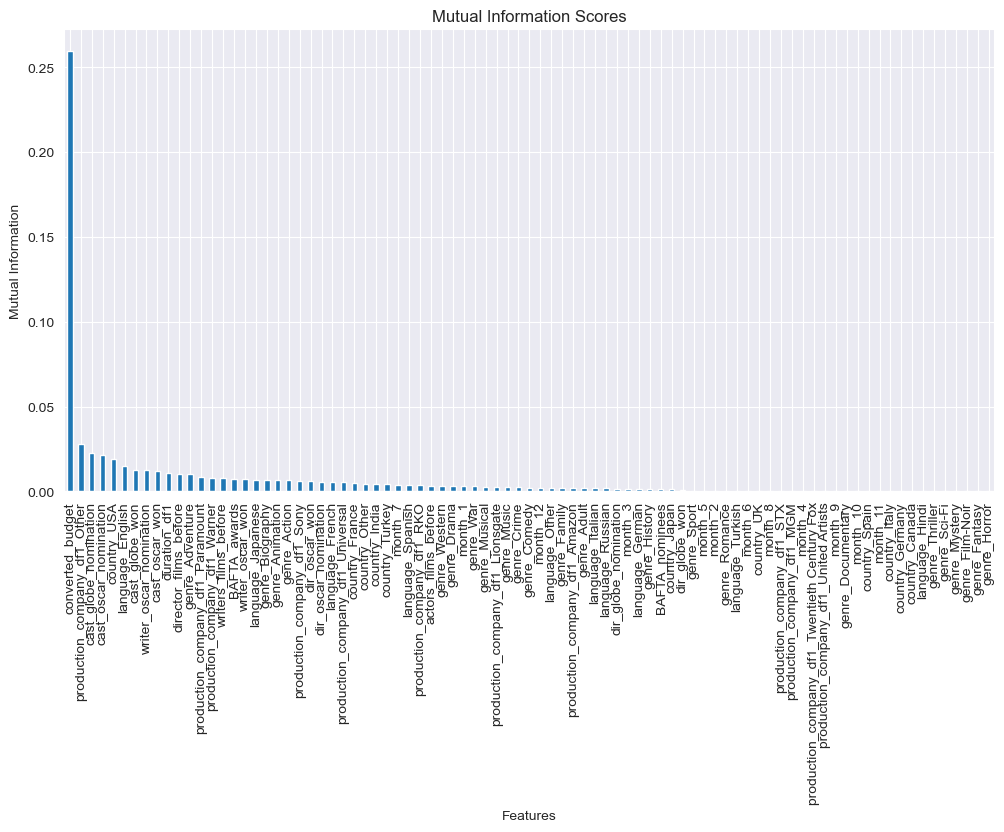

Selected features based on Mutual Information:
Index(['converted_budget', 'production_company_df1_Other',
       'cast_globe_nomination', 'cast_oscar_nomination', 'country_USA',
       'language_English', 'cast_globe_won', 'writer_oscar_nomination',
       'cast_oscar_won', 'duration_df1', 'director_films_before',
       'genre_Adventure', 'production_company_df1_Paramount',
       'production_company_df1_Warner', 'writers_films_before', 'BAFTA_awards',
       'writer_oscar_won', 'language_Japanese', 'genre_Biography',
       'genre_Animation', 'genre_Action', 'production_company_df1_Sony',
       'dir_oscar_won', 'dir_oscar_nomination', 'language_French',
       'production_company_df1_Universal', 'country_France', 'country_Other',
       'country_India', 'country_Turkey', 'month_7', 'language_Spanish',
       'production_company_df1_RKO', 'actors_films_before', 'genre_Western',
       'genre_Drama', 'month_1', 'genre_War', 'genre_Musical',
       'production_company_df1_Lionsgate', '

In [159]:
# Applica one-hot encoding alla colonna 'month_published'
X_train = pd.get_dummies(X_train, columns=['month_published'], prefix='month')

# Mantieni solo le colonne dei mesi
month_columns = [col for col in X_train.columns if col.startswith('month_')]
X_train = X_train[month_columns + [col for col in X_train.columns if not col.startswith('month_')]]

# Applica one-hot encoding alle colonne 'genre', 'language', 'country' e 'production_company_df1'
X_train = multi_value_one_hot(X_train, 'language')
X_train = multi_value_one_hot(X_train, 'country')
X_train = multi_value_one_hot(X_train, 'production_company_df1')

# Rimuovi le colonne originali 'genre', 'language', 'country' e 'production_company_df1'
X_train.drop(columns=['language', 'country', 'production_company_df1'], inplace=True)

# Rimuovi righe con NaN nella colonna 'converted_budget'
X_train = X_train.dropna(subset=['converted_budget'])


# Calcola la mutual information tra ogni feature e la variabile target
mi = mutual_info_classif(X_train, y_train, discrete_features='auto', random_state=42)

# Crea un DataFrame per visualizzare i punteggi
mi_scores = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)

# Traccia un grafico dei punteggi di mutual information
plt.figure(figsize=(12, 6))
mi_scores.plot(kind='bar')
plt.title('Mutual Information Scores')
plt.ylabel('Mutual Information')
plt.xlabel('Features')
plt.show()

# Identifica il punto di taglio (puoi osservare il grafico per trovare un calo significativo)
threshold = 0.001  # Esempio di soglia, puoi modificare in base al grafico

# Seleziona le feature con punteggi di mutual information sopra la soglia
selected_features_mi = mi_scores[mi_scores > threshold].index
print("Selected features based on Mutual Information:")
print(selected_features_mi)


X_train_resampled = X_train_resampled[selected_features_mi.to_list()]
X_test = X_test[selected_features_mi.to_list()]

# Verifica del risultato
print(X_train_resampled.head())

In [160]:

# Addestra il modello Random Forest
rf_classifier = RandomForestClassifier(n_jobs=10, n_estimators=500, max_features=10)
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Fai previsioni sui dati di test
y_pred_test = rf_classifier.predict(X_test)

# Fai previsioni sui dati di train
y_pred_train = rf_classifier.predict(X_train_resampled)

# Calcola le metriche di valutazione per il test set
accuracy_test = accuracy_score(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# Calcola le metriche di valutazione per il train set
accuracy_train = accuracy_score(y_train_resampled, y_pred_train)
report_train = classification_report(y_train_resampled, y_pred_train)
conf_matrix_train = confusion_matrix(y_train_resampled, y_pred_train)

print(f'Test Set - Accuracy: {accuracy_test}')
print(f'Test Set - Classification Report:\n{report_test}')
print(f'Test Set - Confusion Matrix:\n{conf_matrix_test}')

print(f'\nTrain Set - Accuracy: {accuracy_train}')
print(f'Train Set - Classification Report:\n{report_train}')
print(f'Train Set - Confusion Matrix:\n{conf_matrix_train}')




Test Set - Accuracy: 0.494647201946472
Test Set - Classification Report:
                        precision    recall  f1-score   support

          0-50,000,000       0.96      0.43      0.60      2802
50,000,000-500,000,000       0.32      0.60      0.42      1123
          500,000,000+       0.19      0.79      0.31       185

              accuracy                           0.49      4110
             macro avg       0.49      0.61      0.44      4110
          weighted avg       0.75      0.49      0.53      4110

Test Set - Confusion Matrix:
[[1212 1382  208]
 [  51  675  397]
 [   3   36  146]]

Train Set - Accuracy: 1.0
Train Set - Classification Report:
                        precision    recall  f1-score   support

          0-50,000,000       1.00      1.00      1.00      4545
50,000,000-500,000,000       1.00      1.00      1.00      4545
          500,000,000+       1.00      1.00      1.00      4545

              accuracy                           1.00     13635
        

In [147]:
adaboost_classifier = AdaBoostClassifier(random_state=42)

# Allena il modello
adaboost_classifier.fit(X_train_resampled, y_train_resampled)

# Fai previsioni sui dati di test
y_pred_test = adaboost_classifier.predict(X_test)

y_pred_train = adaboost_classifier.predict(X_train_resampled)

# Calcola le metriche di valutazione per il test set
accuracy_test = accuracy_score(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)


# Calcola le metriche di valutazione per il test set
accuracy_train = accuracy_score(y_train_resampled, y_pred_train)
report_train = classification_report(y_train_resampled, y_pred_train)
conf_matrix_train = confusion_matrix(y_train_resampled, y_pred_train)

print(f'Test Set - Accuracy: {accuracy_test}')
print(f'Test Set - Classification Report:\n{report_test}')
print(f'Test Set - Confusion Matrix:\n{conf_matrix_test}')

print(f'\nTrain Set - Accuracy: {accuracy_train}')
print(f'Train Set - Classification Report:\n{report_train}')
print(f'Train Set - Confusion Matrix:\n{conf_matrix_train}')



Test Set - Accuracy: 0.4927007299270073
Test Set - Classification Report:
                        precision    recall  f1-score   support

          0-50,000,000       0.95      0.49      0.64      2802
50,000,000-500,000,000       0.30      0.45      0.36      1123
          500,000,000+       0.16      0.86      0.27       185

              accuracy                           0.49      4110
             macro avg       0.47      0.60      0.42      4110
          weighted avg       0.73      0.49      0.55      4110

Test Set - Confusion Matrix:
[[1360 1146  296]
 [  72  506  545]
 [   7   19  159]]

Train Set - Accuracy: 0.7224055738907224
Train Set - Classification Report:
                        precision    recall  f1-score   support

          0-50,000,000       0.73      0.79      0.76      4545
50,000,000-500,000,000       0.62      0.58      0.60      4545
          500,000,000+       0.80      0.80      0.80      4545

              accuracy                           0.72   

In [148]:
# Definizione del classificatore Gradient Boosting
gradient_boosting_classifier = GradientBoostingClassifier(random_state=42)

# Allena il modello
gradient_boosting_classifier.fit(X_train_resampled, y_train_resampled)

# Fai previsioni sui dati di test
y_pred_test = gradient_boosting_classifier.predict(X_test)
y_pred_train = gradient_boosting_classifier.predict(X_train_resampled)

# Calcola le metriche di valutazione per il test set
accuracy_test = accuracy_score(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# Calcola le metriche di valutazione per il train set
accuracy_train = accuracy_score(y_train_resampled, y_pred_train)
report_train = classification_report(y_train_resampled, y_pred_train)
conf_matrix_train = confusion_matrix(y_train_resampled, y_pred_train)

print(f'Test Set - Accuracy: {accuracy_test}')
print(f'Test Set - Classification Report:\n{report_test}')
print(f'Test Set - Confusion Matrix:\n{conf_matrix_test}')

print(f'\nTrain Set - Accuracy: {accuracy_train}')
print(f'Train Set - Classification Report:\n{report_train}')
print(f'Train Set - Confusion Matrix:\n{conf_matrix_train}')


Test Set - Accuracy: 0.46131386861313867
Test Set - Classification Report:
                        precision    recall  f1-score   support

          0-50,000,000       0.95      0.42      0.58      2802
50,000,000-500,000,000       0.29      0.50      0.37      1123
          500,000,000+       0.17      0.86      0.28       185

              accuracy                           0.46      4110
             macro avg       0.47      0.60      0.41      4110
          weighted avg       0.74      0.46      0.51      4110

Test Set - Confusion Matrix:
[[1169 1355  278]
 [  56  567  500]
 [   3   22  160]]

Train Set - Accuracy: 0.7763843050971764
Train Set - Classification Report:
                        precision    recall  f1-score   support

          0-50,000,000       0.80      0.78      0.79      4545
50,000,000-500,000,000       0.67      0.71      0.69      4545
          500,000,000+       0.87      0.84      0.85      4545

              accuracy                           0.78  

In [ ]:
# Carica il dataset
df = pd.read_csv('only_one_language_country.csv')

# Creazione della colonna 'revenue_cluster'
bins = [0, 50000000, 500000000, np.inf]
labels = ['0-50,000,000', '50,000,000-500,000,000', '500,000,000+']
df['revenue_cluster'] = pd.cut(df['revenue_with_CPI'], bins=bins, labels=labels, right=False)

# Selezione delle colonne rilevanti
columns_to_keep = [
    'genre', 'duration_df1', 'date_published', 'language', 'country', 'converted_budget',
    'dir_oscar_nomination', 'dir_oscar_won', 'writer_oscar_nomination',
    'BAFTA_nominees', 'BAFTA_awards', 'writer_oscar_won', 'cast_oscar_nomination',
    'cast_oscar_won', 'dir_globe_nomination', 'dir_globe_won', 'production_company_df1',
    'cast_globe_nomination', 'cast_globe_won', 'actors_films_before',
    'director_films_before', 'writers_films_before', 'revenue_cluster'
]

df_selected = df[columns_to_keep].dropna()

# Funzione per one-hot encoding su colonne con valori multipli separati da virgole
def multi_value_one_hot(df, column):
    s = df[column].str.get_dummies(sep=', ')
    return df.join(s.add_prefix(column + '_'))

# Encoding dei generi
df_selected = multi_value_one_hot(df_selected, 'genre')
df_selected.drop(columns=['genre'], inplace=True)

# Converti 'date_published' in formato datetime e estrai il mese
df_selected['date_published'] = pd.to_datetime(df_selected['date_published'], errors='coerce')
df_selected['month_published'] = df_selected['date_published'].dt.month
df_selected.drop(columns=['date_published'], inplace=True)

# Separazione delle feature e del target
X = df_selected.drop('revenue_cluster', axis=1)
y = df_selected['revenue_cluster']

# Definizione delle colonne categoriche e numeriche
categorical_features = ['language', 'country', 'production_company_df1', 'month_published']
categorical_features += [col for col in X.columns if col.startswith('genre_')]
numerical_features = ['duration_df1', 'converted_budget', 'dir_oscar_nomination', 'dir_oscar_won', 'writer_oscar_nomination', 
                      'writer_oscar_won', 'cast_oscar_nomination', 'cast_oscar_won', 'dir_globe_nomination', 'dir_globe_won', 
                      'cast_globe_nomination', 'cast_globe_won', 'BAFTA_nominees', 'BAFTA_awards', 'actors_films_before', 
                      'director_films_before', 'writers_films_before']

# Pipeline per il preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'
)

# Definizione della pipeline di modellazione
pipeline = ImbPipeline([
    ('preprocess', preprocessor),
    ('under', RandomUnderSampler(sampling_strategy='majority', random_state=42)),
    ('over', SMOTENC(categorical_features=[X.columns.get_loc(col) for col in categorical_features], random_state=42)),
    ('feature_selection', SelectKBest(mutual_info_classif, k=20)),  # Esempio di selezione delle 20 migliori feature
    ('classifier', RandomForestClassifier(n_jobs=10, n_estimators=500, max_features=10, random_state=42))
])

# Esecuzione della cross-validation
scores = cross_val_score(pipeline, X, y, cv=10, scoring='accuracy')

print(f'Cross-Validation Accuracy Scores: {scores}')
print(f'Mean Accuracy: {scores.mean()}')

# Adattamento finale e valutazione
pipeline.fit(X, y)
y_pred = pipeline.predict(X)

# Valutazione del modello
print(f'Accuracy: {accuracy_score(y, y_pred)}')
print(f'Classification Report:\n{classification_report(y, y_pred)}')
print(f'Confusion Matrix:\n{confusion_matrix(y, y_pred)}')
